# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [3]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

A lot of the dataloading syntax and concepts below should hopefully be review from HW 1!

In [9]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# We will set up an 80-20 training validation split.
# That is, we will designate 80% of the 50k samples in the CIFAR10 training data as our training set
# and the remaining 20% as the validation set
train_size = 40_000
val_size = 10_000

dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

Files already downloaded and verified


In [10]:
# This line will create the PyTorch dataloaders associated with the training and validation sets.
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

Note that we have downloaded our dataset, let's visualize a few images from it!

showing training images


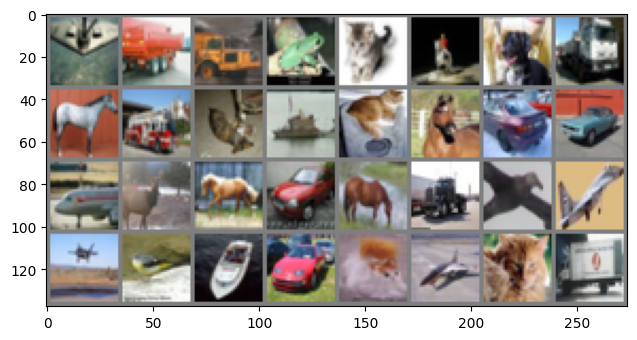


... and their corresponding labels
plane    truck    truck    frog     cat      horse    dog      truck   
horse    truck    cat      ship     cat      horse    car      car     
plane    deer     horse    car      horse    truck    bird     plane   
plane    bird     ship     car      cat      plane    cat      truck   


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. This also means that every pixel in our image input is connected to every neuron in its immediate next layer. Recall that this is just the Multi-Layer Perceptron that we introduced in the deep learning lecture.

An MLP/FCNN network must take in a vector as input. However, we are passing images to the network below? How do we convert an image to a vector? We can simply flatten it! Any `C x H x W` image can also be represented by a `C*H*W` dimensional vector of its pixel values, which is what we will use as the actual input to your model layers.

Let's try implementing this approach below!

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future use
        layer_dims: list of integers: the first integer is the input dimension
            and all subsequent elements represent the width
            of each layer in our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        For example, if layer_dims = [100, 50, 10], then this multi-layer
        perceptron will have two linear layers: the first layer will take
        inputs of dimension 100 and output tensors of dimension 50, and the
        second layer will take inputs of dimension 50 and output tensors of
        dimension 10.
        '''
        ## YOUR CODE HERE
        ## TODO: Remember your call to super!
        super(FCNN, self).__init__()
        ## TODO: Create some linear layers that you can call in the foward
        self.fc1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc2 = nn.Linear(layer_dims[1], layer_dims[2])
        ## pass below.
        ## You may either hard-code that there will be 3 layers,
        ## or you can look into torch.nn.ModuleList()

        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Flatten the images; remeber that x has a whole batch!
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        ## TODO: Apply each of the layers and relu after each one
        ## END YOUR CODE

Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    ## YOUR CODE HERE
    ## TODO: Put the model on the right device (may not always be CPU)
    model.to(device)
    ## TODO: Enable eval mode on the model
    model.eval()
    ## END YOUR CODE

    for inputs, labels in tqdm(loader, leave=False):
        ## YOUR CODE HERE
        ## TODO: Move the inputs and labels to the right device
        inputs = inputs.to(device)
        labels = labels.to(device)
        ## TODO: Compute the model outputs
        outputs = model(inputs)
        ## TODO: Calculate the number of correct predictions (hint: use torch.argmax)
        garbage, predicted = torch.max(outputs, 1)
        ## TODO: Update the total number of correct predictions
        total_correct += (predicted == labels).sum().item()
        ## END YOUR CODE
    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
      os.makedirs(path)

    ## YOUR CODE HERE
    ## TODO: Put the model on the right device (may not always be CPU)
    model.to(device)
    ## END YOUR CODE

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            ## YOUR CODE HERE
            ## TODO: Move the inputs and labels to the right device
            inputs = inputs.to(device)
            labels = labels.to(device)
            ## TODO: Zero out the gradients
            optimizer.zero_grad()
            ## TODO: Compute the model outputs
            outputs = model(inputs)
            ## TODO: Calculate the loss
            loss = criterion(outputs, labels)
            ## TODO: Backpropagate the gradients with respect to the loss
            loss.backward()
            ## TODO: Perform an optimizer step
            optimizer.step()
            ## TODO: Update the total loss with the current loss
            total_loss += loss.item()
            ## END YOUR CODE

        if path:
          torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')
        end_time = time.perf_counter()
        duration = end_time - start_time

        ## YOUR CODE HERE
        ## TODO: Compute the training and validation accuracies (hint: use compute_accuracy())
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        ## END YOUR CODE

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2285.470	time: 15.707	train acc: 0.4216	val acc: 0.4171


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2012.193	time: 16.612	train acc: 0.4652	val acc: 0.4489


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1908.615	time: 15.471	train acc: 0.4874	val acc: 0.4621


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1837.061	time: 15.903	train acc: 0.5017	val acc: 0.4702


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1780.356	time: 15.631	train acc: 0.5238	val acc: 0.4827


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1732.073	time: 16.100	train acc: 0.5348	val acc: 0.4868


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1687.268	time: 16.930	train acc: 0.5491	val acc: 0.4967


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1649.456	time: 16.011	train acc: 0.5597	val acc: 0.5008


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1612.486	time: 17.038	train acc: 0.5732	val acc: 0.5003


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1578.238	time: 17.008	train acc: 0.5770	val acc: 0.5017


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1549.173	time: 15.772	train acc: 0.5885	val acc: 0.5130


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1518.698	time: 15.875	train acc: 0.5983	val acc: 0.5110


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1489.984	time: 16.095	train acc: 0.6078	val acc: 0.5112


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1464.719	time: 15.870	train acc: 0.6061	val acc: 0.5125


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1437.884	time: 16.870	train acc: 0.6228	val acc: 0.5138


As a final observation, let's print the number of parameters that this network learned.

In [ ]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

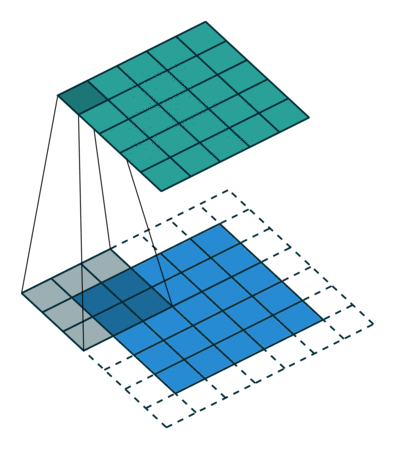

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network. You should check out the PyTorch documentation for [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to learn more about how these layers should be defined.

In the fully-connected neural network above, we had to flatten each image (or flatten a batch of images) before they could be passed into our linear layers. Do we also need to flatten them before they are passed into a convolutional layer? Hint: look at the documentation above to find out the tensor shape a Conv2D layer expects its input to have.

In [1]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future use.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''
        ## YOUR CODE HERE
        ## TODO: Define your layers
        super(CNN, self).__init__()
        ## END YOUR CODE
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which the input gets passed through
        the layers.

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Call your convolutional layers, with activation and pooling.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        ## TODO: Flatten your output so it can be passed into linear layers
        x = x.view(-1, 16*5*5)
        ## TODO: Call your linear layers, with activation.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ## TODO: Remember NOT to call activation after final fully connected layer!
        return x
        ## END YOUR CODE

NameError: name 'nn' is not defined

In [ ]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2834.469	time: 22.074	train acc: 0.2500	val acc: 0.2528


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2467.899	time: 21.338	train acc: 0.3370	val acc: 0.3447


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2136.885	time: 21.966	train acc: 0.4114	val acc: 0.4087


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1949.149	time: 21.111	train acc: 0.4624	val acc: 0.4550


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1825.430	time: 23.397	train acc: 0.4910	val acc: 0.4827


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1744.029	time: 21.867	train acc: 0.5043	val acc: 0.4939


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1671.651	time: 22.265	train acc: 0.5380	val acc: 0.5279


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1609.807	time: 21.329	train acc: 0.5590	val acc: 0.5395


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1554.903	time: 22.207	train acc: 0.5778	val acc: 0.5521


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1507.558	time: 22.708	train acc: 0.5868	val acc: 0.5622


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1469.178	time: 22.659	train acc: 0.5923	val acc: 0.5641


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1431.072	time: 23.594	train acc: 0.6139	val acc: 0.5838


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1393.868	time: 22.557	train acc: 0.6169	val acc: 0.5770


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1360.454	time: 22.142	train acc: 0.6261	val acc: 0.5840


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1326.615	time: 22.413	train acc: 0.6433	val acc: 0.6008


In [ ]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead so they can skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model. We will then chain these blocks to contruct the overall ResNet model.

In [4]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be a no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        ## YOUR CODE HERE
        ## TODO: Initialize the block with a call to super and make your conv and batchnorm layers.
        super(ResNetBlock, self).__init__()
        ## TODO: Use some conditional logic when defining your shortcut layer
        self.conv1 = nn. Conv2d (in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn. BatchNorm2d (out_channels)
        self.conv2 = nn. Conv2d (out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn. BatchNorm2d (out_channels)
        ## For a no-op layer, consider creating an empty nn.Sequential()
        if stride != 1 or in_channels != out_channels:
          self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))
        else:
          self.shortcut = nn.Sequential()
        ## END YOUR CODE

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data with this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        ## YOUR CODE HERE
        ## TODO: Call the first convolution, batchnorm, and activation
        out = F.relu(self.bn1(self.conv1(x)))
        ## TODO: Call the second convolution and batchnorm
        out = self.bn2(self.conv2(out))
        ## TODO: Also call the shortcut layer on the original input
        out += self.shortcut(x)
        ## TODO: Sum the result of the shortcut and the result of the second batchnorm
        out = F.relu(out)
        ## and apply your activation
        ## TODO: Return the result
        return out
        ## END YOUR CODE

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [ ]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [ ]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
       ResNetBlock-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
      ResNetBlock-12           [32, 64, 32, 32]               0
           Conv2d-13          [32, 128, 16, 16]          73,728
      BatchNorm2d-14          [32, 128,

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1676.087	time: 2731.802	train acc: 0.6233	val acc: 0.5839


  0%|          | 0/1250 [00:00<?, ?it/s]

And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 85%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentations. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are some things you can probably experiment with:
- Batch size
- Learning rate
- Optimizer
- Number of epochs
- Image transforms/augmentations
- Adding/removing/modifying conv and linear layers
- Adding dropout, batchnorm, etc.

In [5]:
try:
    import shutil
    shutil.rmtree("./data")
    del train_loader, val_loader
except:
    pass

data_root = './data/cifar10'
train_size = 40_000
val_size = 10_000

## YOUR CODE HERE
## TODO: Modify the given transforms and hyperparameters if you wish to
## Don't remove T.Normalize. If you wish to normalize differently,
## change the mean and std lists below.
batch_size = 32

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    T.Normalize(mean, std),
])
## END YOUR CODE

transform_val = T.Compose([
    T.Normalize(mean, std),
])

dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=T.ToTensor()
)

assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_split, val_split, _ = torch.utils.data.random_split(
    range(len(dataset)), [train_size, val_size, len(dataset) - train_size - val_size]
)

class CustomTransformDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.transform = transform
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        return self.transform(x), y

train_set = CustomTransformDataset(dataset, train_split, transform=transform_train)
val_set = CustomTransformDataset(dataset, val_split, transform=transform_val)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

100%|██████████| 170498071/170498071 [00:01<00:00, 93087614.13it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


You can visualize the effects of your data augmentations on the training set by running the cell below:

showing training images


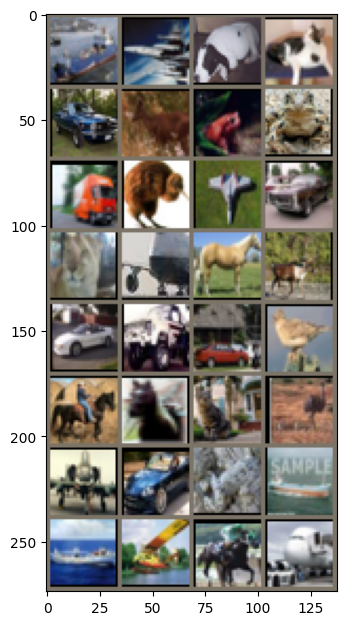


... and their corresponding labels
ship     plane    dog      cat     
car      deer     frog     frog    
truck    bird     plane    car     
cat      plane    horse    deer    
car      truck    car      bird    
horse    horse    cat      bird    
plane    car      frog     ship    
ship     plane    horse    plane   


In [6]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 8
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

In [7]:
## Feel free to create a bigger resnet model, or use a completely different CNN architecture.
## You can also choose to modify the ResNet model above (in which case, we do ask that you copy it down below
## before making any changes to it; we want to keep your implementation above separate for the model you define
## here for grading purposes).
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.

import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # ResNet blocks
        self.layer1 = self._make_layer(ResNetBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 256, 512, 2, stride=2)
        # Adaptive pooling and fully connected layer for classification
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        # The first block might reduce dimensions
        layers.append(block(in_channels, out_channels, stride=stride))
        # The rest of the blocks keep dimensions
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

final_cnn = ResNet() # TODO

In [12]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters if you wish
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=1e-3, momentum=0.9)
## You can also add a learning rate scheduler if you want to experiment with one
scheduler = None # Change this to a scheduler (optional)
## END YOUR CODE

train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1698.116	time: 44.294	train acc: 0.6317	val acc: 0.6036


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1084.904	time: 43.668	train acc: 0.7762	val acc: 0.7007


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 780.215	time: 44.194	train acc: 0.8347	val acc: 0.7365


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 547.732	time: 43.764	train acc: 0.9151	val acc: 0.7548


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 346.831	time: 44.077	train acc: 0.9289	val acc: 0.7418


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 220.065	time: 43.833	train acc: 0.9717	val acc: 0.7697


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 149.252	time: 44.230	train acc: 0.9707	val acc: 0.7604


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 110.338	time: 43.940	train acc: 0.9782	val acc: 0.7589


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 63.056	time: 43.411	train acc: 0.9828	val acc: 0.7697


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 46.110	time: 43.777	train acc: 0.9922	val acc: 0.7755


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 38.182	time: 43.598	train acc: 0.9911	val acc: 0.7816


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 25.342	time: 44.527	train acc: 0.9968	val acc: 0.7846


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 29.843	time: 44.093	train acc: 0.9967	val acc: 0.7890


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 19.157	time: 44.347	train acc: 0.9994	val acc: 0.7963


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 10.510	time: 44.288	train acc: 0.9998	val acc: 0.8006


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [13]:
import pickle

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("cnn_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

100%|██████████| 170498071/170498071 [00:01<00:00, 100886301.03it/s]


Extracting ./cifar-10-python.tar.gz to .
